<a target="_blank" href="https://colab.research.google.com/github/FlorianWolff95/DHBW_BI_S24/blob/main/ML_Fallstudie_Obesity.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ML Fallstudie Obesity
Sie finden in unserem [Repo](https://github.com/AlexKressner/Business_Intelligence) unter `Daten/Obesity/` Daten zur Schätzung der Adipositaslevel von Personen aus den Ländern Mexiko, Peru und Kolumbien, im Alter zwischen 14 und 61 Jahren, mit unterschiedlichen Essgewohnheiten und körperlicher Verfassung. Die Daten wurden mit Hilfe einer Webplattform gesammelt, auf der anonyme Nutzer jede Frage eines Fragebogens beantworteten. Anschließend wurden die Informationen verarbeitet, wobei 17 Attribute und 2111 Datensätze erhalten wurden.

Die mit den Essgewohnheiten verbundenen Attribute sind: Häufiger Konsum von hochkalorischen Lebensmitteln (FAVC), Häufigkeit des täglichen Gemüsekonsums (FCVC), Anzahl der Hauptmahlzeiten pro Tag (NCP), Konsum von Nahrungsmitteln zwischen den Mahlzeiten (CAEC), täglicher Wasserkonsum (CH20) und Alkoholkonsum (CALC).

Die mit der körperlichen Verfassung verbundenen Attribute sind: Überwachung des Kalorienverbrauchs (SCC), Häufigkeit körperlicher Aktivitäten (FAF), Zeit, die mit Technologiegeräten verbracht wird (TUE), genutztes Verkehrsmittel (MTRANS) und die erhaltenen Variablen: Geschlecht, Alter, Größe und Gewicht.

Die verschiedenen Adipositatswerte (in der Spalte `ObesityLevel`) sind:

- Untergewicht
- Normalgewicht
- Übergewicht_I
- Übergewicht_II
- Adipositas_I
- Adipositas_II
- Adipositas_III

Die Daten stammen von [Kaggle](https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster). Ihre Aufgabe besteht darin, ein geeignetes Modell zur Vorhersage des Adipositatlevels basierend auf den gegebenen Features zu erstellen. Beantworten Sie dafür die folgenden Fragestellungen bzw. gehen Sie wie folgt vor:

1. **Vorüberlegung**: Wenn Sie das Adipositaslevel einer Person vorhersagen, handelt es sich um eine Regression oder Klassifikation?

2. **Datenexploration**:
- Wie viele Features gibt es?
- Gibt es fehlende Werte bei den Features?
- Wie sind die numerischen Features verteilt, d.h. berechnen Sie Kenngrößen wie den Mittelwert, Median, Quartile, etc.? Hinweis: Dafür gibt es eine Funktion!
- Wie ist die Korrelation zwischen dem Target und den Features? Hinweis: Dafür gibt es eine Funktion!

3. **Feature Engineering**:
- Achte Sie auf die Datentypen beim Erstellen von Features!
- Gibt es aus Ihrer Sicht weitere interessante Features, die Sie aus den Daten ableiten können?

4. **Modell trainieren und bewerten**:
- Entwickeln Sie ein Modell, mit dem Sie das Adipositaslevel einer Person basierend auf den zur Verfügung stehenden Features schätzen können.
- Optimieren Sie die Hyperparamter Ihres Modells.
- Können Sie Prognosegüte erhöhen, wenn Sie zwei Modelle trainieren? Ein Modell schätzt das Adipositaslevels für Männer, das andere für Frauen.

5. **Prognose**: Schätzen Sie das Adipositaslevel einer beliebigen Person.

In [1]:
#! git clone https://github.com/FlorianWolff95/DHBW_BI_S24

In [2]:
#! pip install optuna

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os


WORKING_DIR = os.getcwd()

if not os.path.exists(os.path.join(WORKING_DIR, "Daten")):
    DATA_DIR = os.path.join(WORKING_DIR, "DHBW_BI_S24", "Daten")
else:
    DATA_DIR = os.path.join(WORKING_DIR, "Daten")

In [4]:
df = pd.read_csv(os.path.join(DATA_DIR, "Obesity", "ObesityDataSet.csv"))
df.columns = df.columns.str.strip().str.lower()
df.head()

,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
full_col_names = dict(
    {
        "fcvc": "Frequent consumption of high caloric food",
        "fcva": "Frequency of consumption of vegetables",
        "ncp": "Number of main meal",
        "caec": "Consumption of food between meals",
        "ch2o": "Consumption of water daily",
        "scc": "Calories consumption monitoring",
        "faf": "Physical activity frequency",
        "tue": "Time using technology devices",
        "calc": "Consumption of alcohol",
        "mtrans": "Transportation used",
    }
)

## 1. **Vorüberlegung:** Es handelt sich um MultiClass Klassifikation.

## 2. **Datenexploration**

Es ist das Ziel anhand des Essverhaltens, Alter und Geschlecht vorherzusagen welches Adiporitaslevel `NObeyesdad` hat.
Da `NObeyesdad` bestimmt wird über den `BMI`, welcher sich berechnet aus `height` und `weight`, können diese Spalten nicht zur Vorhersage verwendet werden.

In [6]:
FEATURES = [
    "age",
    "family_history_with_overweight",
    "favc",
    "ncp",
    "caec",
    "smoke",
    "ch2o",
    "scc",
    "faf",
    "tue",
    "mtrans",
    "calc",
]
TARGET = "nobeyesdad"

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          2111 non-null   object 
 1   age                             2111 non-null   float64
 2   height                          2111 non-null   float64
 3   weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   favc                            2111 non-null   object 
 6   fcvc                            2111 non-null   float64
 7   ncp                             2111 non-null   float64
 8   caec                            2111 non-null   object 
 9   smoke                           2111 non-null   object 
 10  ch2o                            2111 non-null   float64
 11  scc                             2111 non-null   object 
 12  faf                             21

In [8]:
col_cat = ["gender", "caec", "calc", "mtrans", "nobeyesdad"]
cat_bool = ["family_history_with_overweight", "favc", "smoke", "scc"]
cat_num = df.select_dtypes("float64").columns.tolist()

df[col_cat] = df[col_cat].astype("category")

df[cat_bool] = df[cat_bool].replace({"no": 0, "yes": 1}).astype("bool")

In [9]:
df.head()

,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
0,Female,21.0,1.62,64.0,True,False,2.0,3.0,Sometimes,False,2.0,False,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,True,False,3.0,3.0,Sometimes,True,3.0,True,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,True,False,2.0,3.0,Sometimes,False,2.0,False,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,False,False,3.0,3.0,Sometimes,False,2.0,False,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,False,False,2.0,1.0,Sometimes,False,2.0,False,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   gender                          2111 non-null   category
 1   age                             2111 non-null   float64 
 2   height                          2111 non-null   float64 
 3   weight                          2111 non-null   float64 
 4   family_history_with_overweight  2111 non-null   bool    
 5   favc                            2111 non-null   bool    
 6   fcvc                            2111 non-null   float64 
 7   ncp                             2111 non-null   float64 
 8   caec                            2111 non-null   category
 9   smoke                           2111 non-null   bool    
 10  ch2o                            2111 non-null   float64 
 11  scc                             2111 non-null   bool    
 12  faf                 

In [11]:
df.describe()

,age,height,weight,fcvc,ncp,ch2o,faf,tue
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [12]:
# Check for missing values
df.isna().sum()

gender                            0
age                               0
height                            0
weight                            0
family_history_with_overweight    0
favc                              0
fcvc                              0
ncp                               0
caec                              0
smoke                             0
ch2o                              0
scc                               0
faf                               0
tue                               0
calc                              0
mtrans                            0
nobeyesdad                        0
dtype: int64

In [13]:
# distributions of col_cat
for x in col_cat:
    print(df[x].value_counts(normalize=True))
    print("\n")

Male      0.505921
Female    0.494079
Name: gender, dtype: float64


Sometimes     0.836097
Frequently    0.114638
Always        0.025107
no            0.024159
Name: caec, dtype: float64


Sometimes     0.663667
no            0.302700
Frequently    0.033160
Always        0.000474
Name: calc, dtype: float64


Public_Transportation    0.748460
Automobile               0.216485
Walking                  0.026528
Motorbike                0.005211
Bike                     0.003316
Name: mtrans, dtype: float64


Obesity_Type_I         0.166272
Obesity_Type_III       0.153482
Obesity_Type_II        0.140692
Overweight_Level_I     0.137376
Overweight_Level_II    0.137376
Normal_Weight          0.135955
Insufficient_Weight    0.128849
Name: nobeyesdad, dtype: float64




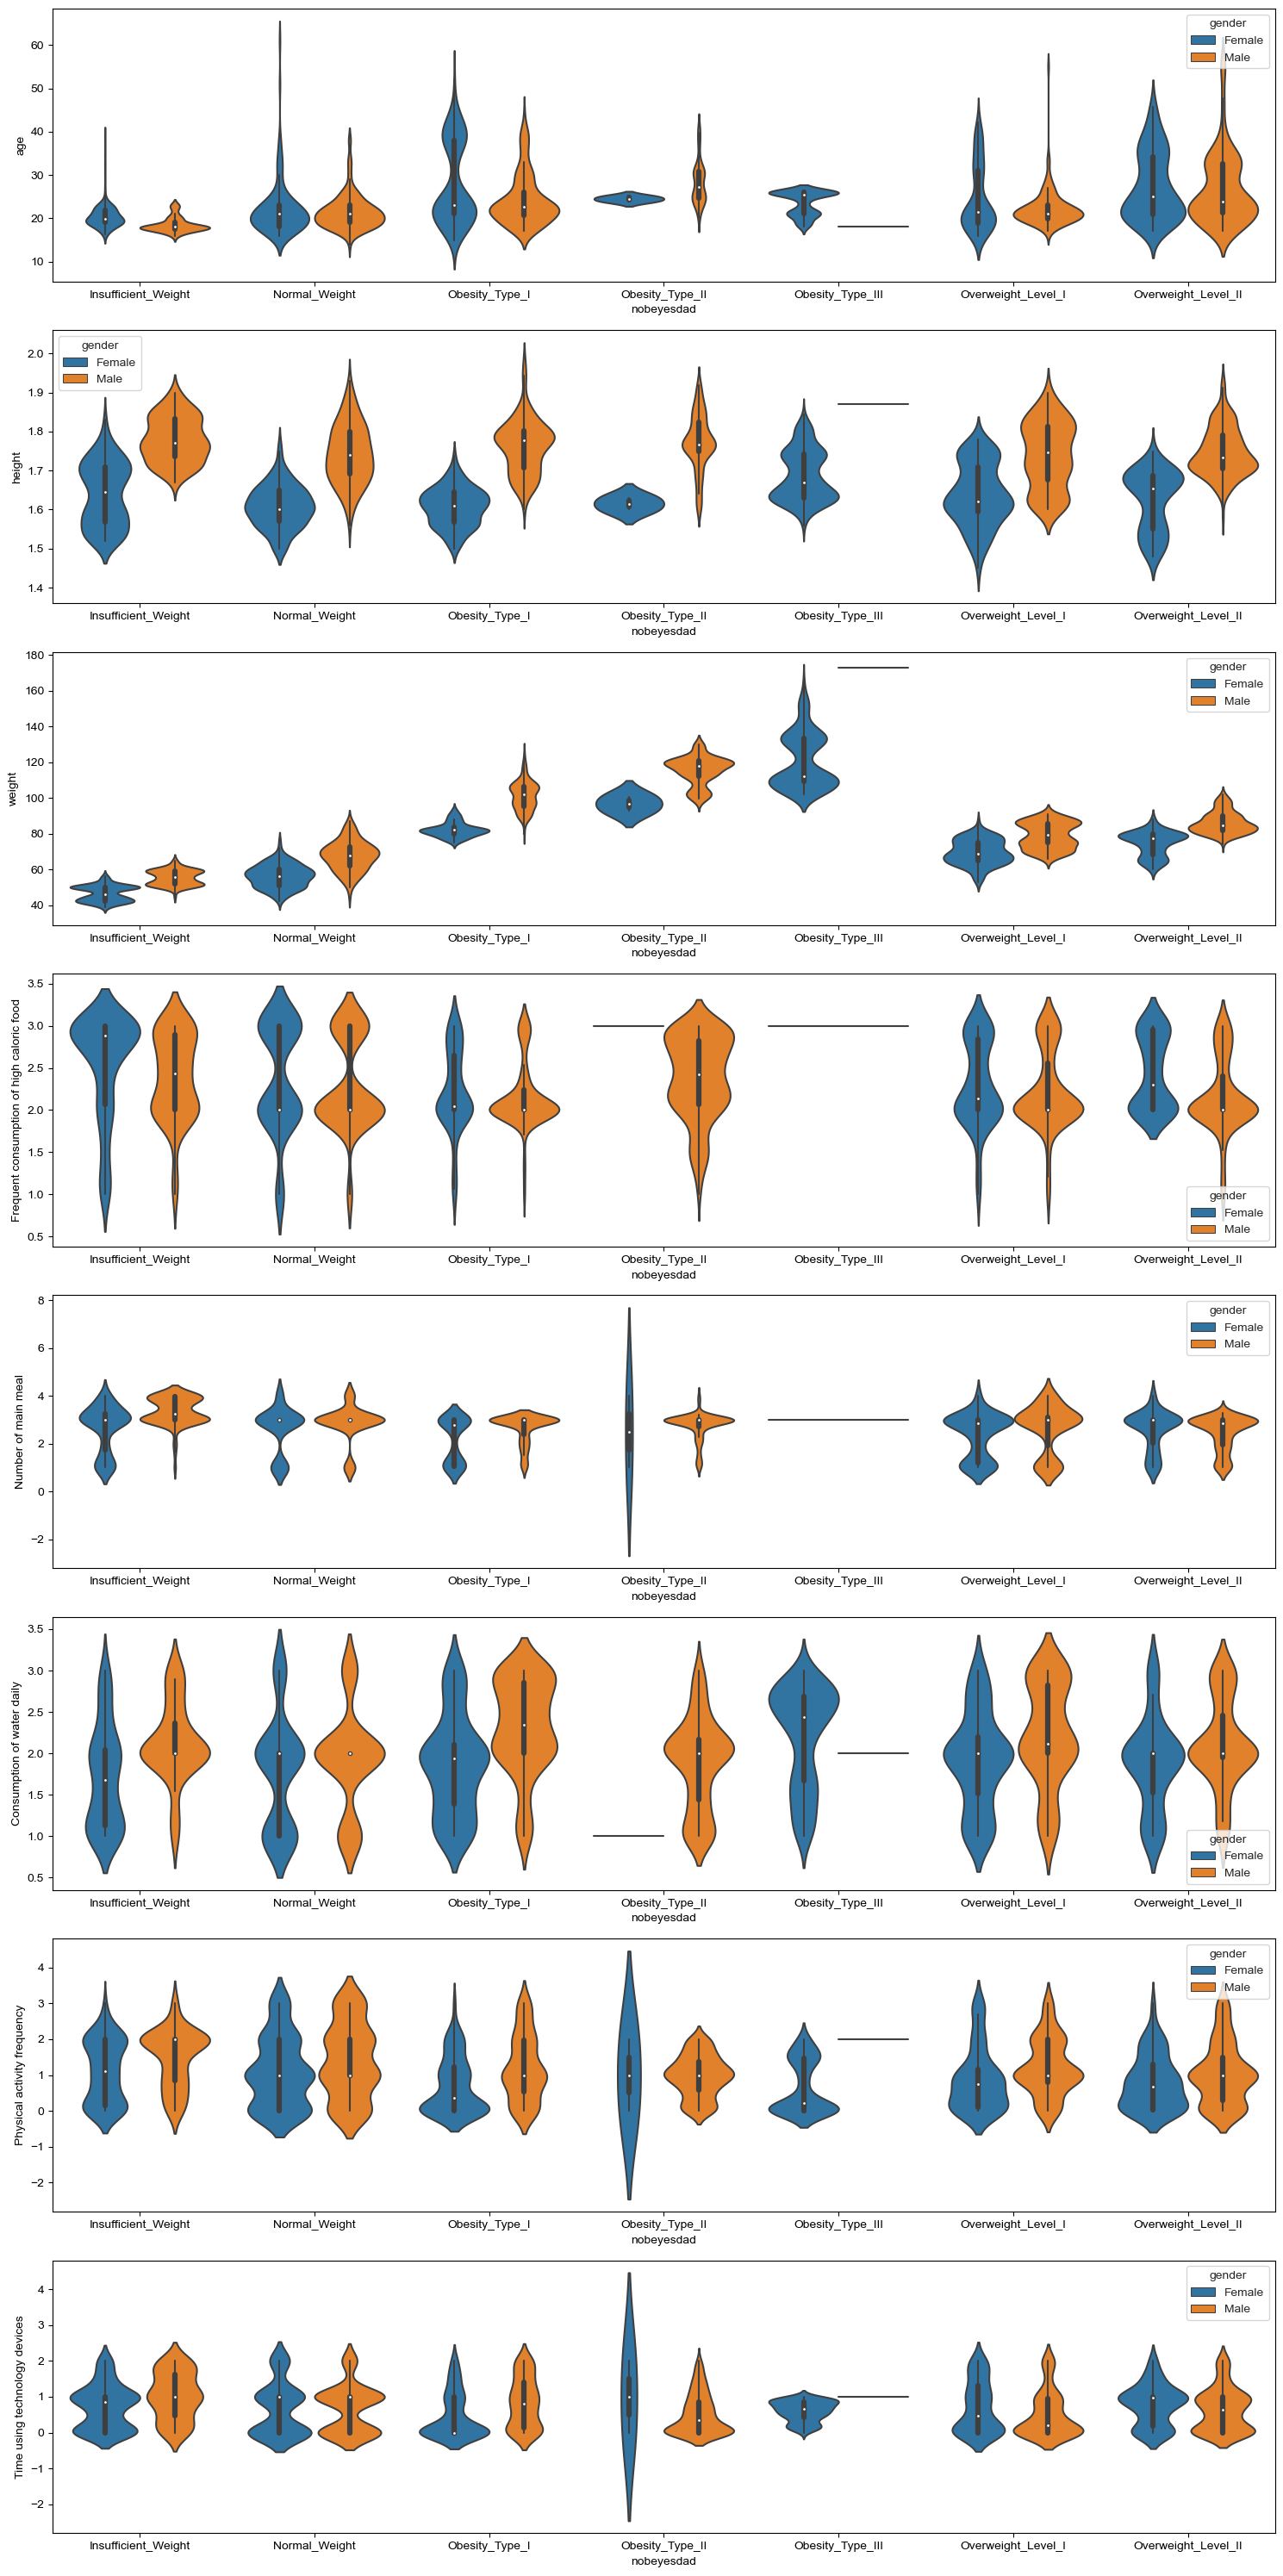

In [14]:
fig, ax = plt.subplots(len(cat_num), 1, figsize=(15, 30), sharex=False)
sns.set_style("whitegrid")
for i, col in enumerate(cat_num):
    sns.violinplot(x=TARGET, y=col, data=df, ax=ax[i], hue="gender", split=False)
    if col in full_col_names.keys():
        ax[i].set_ylabel(full_col_names[col])

plt.tight_layout()
plt.show()

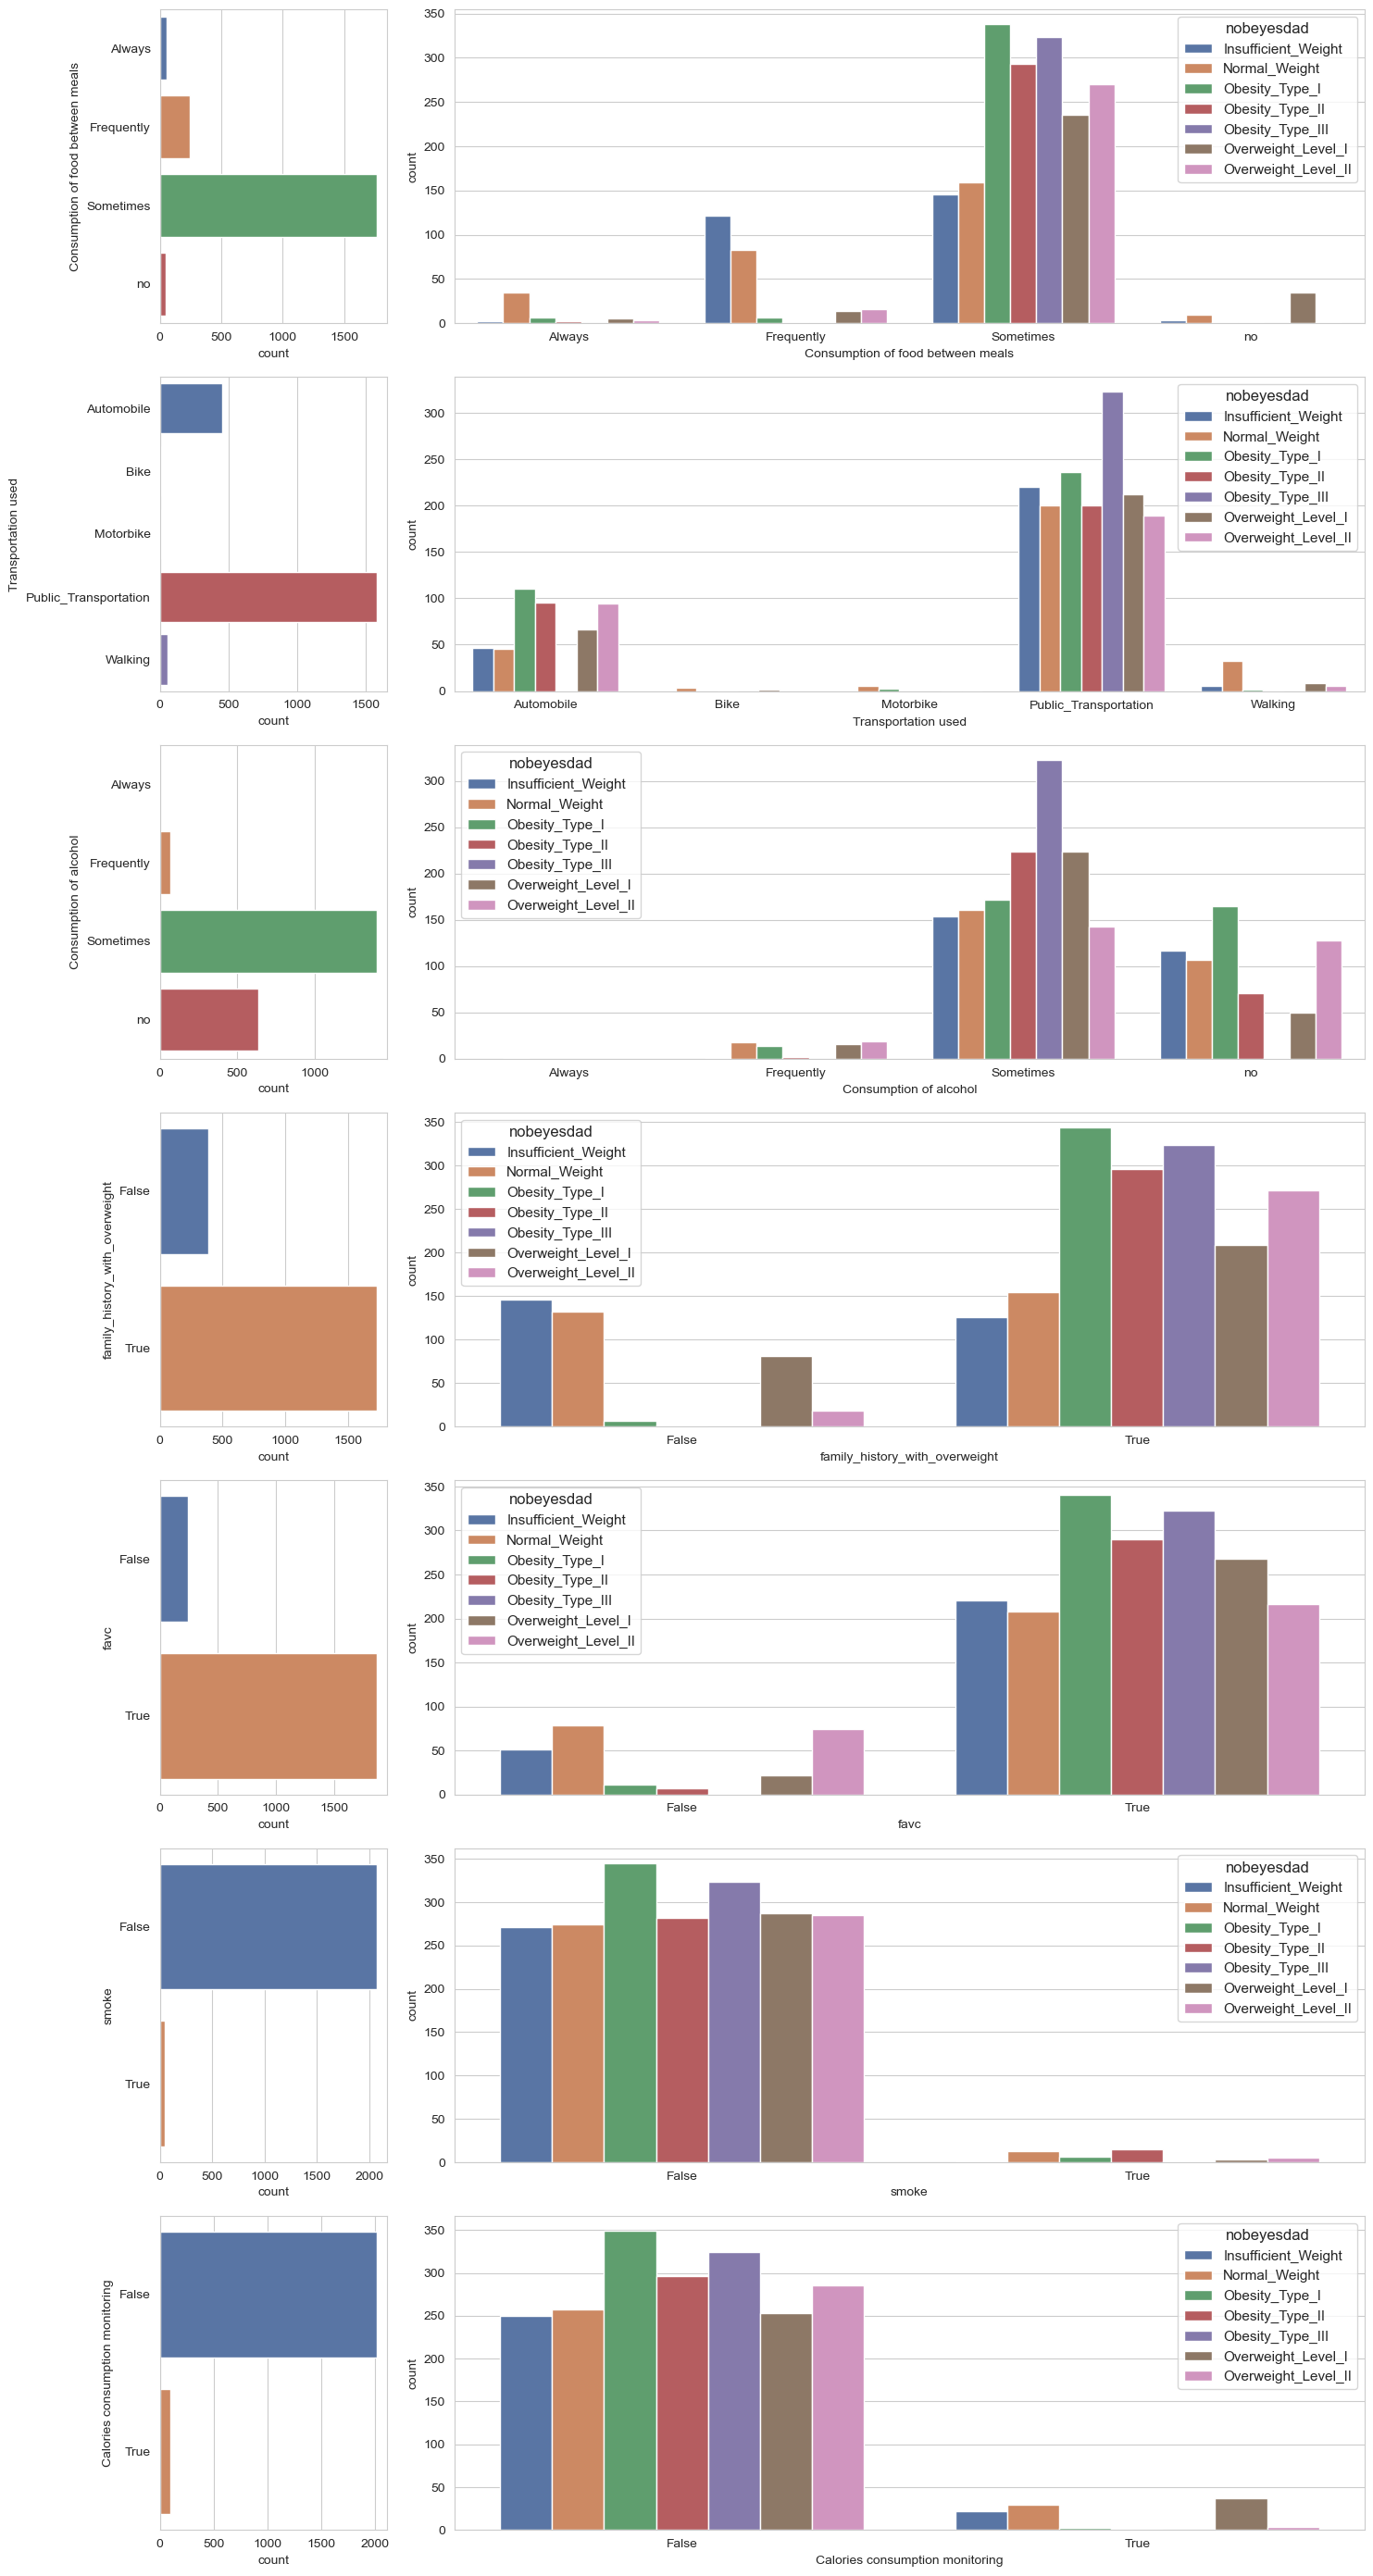

In [15]:
col_features_cat = df[FEATURES].select_dtypes("category").columns.tolist() + cat_bool
_, ax = plt.subplots(
    len(col_features_cat),
    2,
    figsize=(15, len(col_features_cat) * 4),
    width_ratios=[1, 4],
)
sns.set_theme(style="whitegrid")
for i, col in enumerate(col_features_cat):
    sns.countplot(y=col, data=df, ax=ax[i, 0])
    sns.countplot(x=col, data=df, ax=ax[i, 1], hue=TARGET)
    if col in full_col_names.keys():
        ax[i, 0].set_ylabel(full_col_names[col])
        ax[i, 1].set_xlabel(full_col_names[col])

plt.tight_layout()
plt.show()

## 4. Modell trainieren

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import optuna

import joblib
import warnings

try:
    import torch
except:
    pass


warnings.filterwarnings("ignore")


def is_running_in_colab():
    try:
        import google.colab

        return True
    except ImportError:
        return False


if not os.path.exists(os.path.join(WORKING_DIR, "models")):
    MODEL_DIR = os.path.join(WORKING_DIR, "DHBW_BI_S24", "models")
else:
    MODEL_DIR = os.path.join(WORKING_DIR, "models")

model_name = "xgb_model_obesity"
model_path = os.path.join(MODEL_DIR, model_name + ".joblib")

In [17]:
# One hot encoding
one_hot_enc = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(),
            df[FEATURES].select_dtypes("category").columns.tolist(),
        ),
    ],
    remainder="passthrough",
)

# Label encoding
label_enc = LabelEncoder()

# Apply transformations
X = one_hot_enc.fit_transform(df[FEATURES])
y = label_enc.fit_transform(df[TARGET])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
def objective(trial: optuna.Trial):

    params = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
    }
    if params["booster"] in ["gbtree", "dart"]:
        params["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=1)
        params["min_child_weight"] = trial.suggest_int("min_child_weight", 0, 10)
        params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        params["grow_policy"] = trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        )

    if params["booster"] == "dart":
        params["sample_type"] = trial.suggest_categorical(
            "sample_type", ["uniform", "weighted"]
        )
        params["normalize_type"] = trial.suggest_categorical(
            "normalize_type", ["tree", "forest"]
        )
        params["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        params["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    try:
        if torch.cuda.is_available():
            params["device"] = "gpu"
            params["tree_method"] = "gpu_hist"
    except:
        if is_running_in_colab():
            raise Exception("Please enable GPU for this notebook")
        else:
            params["n_jobs"] = -1
            params["tree_method"] = "hist"
    params["objective"] = "multi:softmax"
    params["verbosity"] = 0
    params["num_class"] = 7

    model = XGBClassifier(**params, seed=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    return scores.mean()


xgb_study = optuna.create_study(direction="maximize", study_name="XGBoost")
xgb_study.optimize(objective, n_trials=50)


xgb_classifier = XGBClassifier(**xgb_study.best_params, seed=42)
xgb_model = xgb_classifier.fit(X_train, y_train)
joblib.dump(xgb_model, model_path)

[I 2024-02-20 13:06:22,931] A new study created in memory with name: XGBoost
[I 2024-02-20 13:06:52,334] Trial 0 finished with value: 0.7577212789493091 and parameters: {'booster': 'gbtree', 'lambda': 1.6674382148839432e-08, 'alpha': 0.00030081639459152317, 'subsample': 0.9160744013276474, 'colsample_bytree': 0.5266956575185355, 'learning_rate': 0.006759302591833439, 'n_estimators': 1438, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.012409349618712439, 'gamma': 2.447227682678885e-07, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7577212789493091.
[I 2024-02-20 13:07:16,773] Trial 1 finished with value: 0.7150632978069636 and parameters: {'booster': 'gbtree', 'lambda': 6.030528728391508e-06, 'alpha': 3.483581863459559e-06, 'subsample': 0.32627913103028894, 'colsample_bytree': 0.6836219058880398, 'learning_rate': 0.5797340102403016, 'n_estimators': 1966, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.00022949734023860278, 'gamma': 0.00012002579574362266, 'grow_policy': '

In [ ]:
xgb_model = joblib.load(model_path)
y_pred = xgb_model.predict(X_test)

y_test_inv = label_enc.inverse_transform(y_test)
y_pred_inv = label_enc.inverse_transform(y_pred)

print(
    f"Classification Report:\n\n{classification_report(y_test_inv, y_pred_inv)}\n"
    + "-" * 100
    + "\n"
)

cm = confusion_matrix(y_test_inv, y_pred_inv)
plt.figure(figsize=(10, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=label_enc.classes_,
    yticklabels=label_enc.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("-" * 100 + "\n" + f"Accuracy: {accuracy_score(y_test_inv, y_pred_inv)}\n")
print(
    f'f1-score (combines precision and recall): {f1_score(y_test_inv, y_pred_inv, average="weighted")}\n'
)
print(
    f'Precision (accuracy of positve -> high cost false positives): {precision_score(y_test_inv, y_pred_inv, average="weighted")}\n'
)
print(
    f'Recall (Sensitivity to capture all positive instances -> high cost missing positives): {recall_score(y_test_inv, y_pred_inv, average="weighted")}\n'
    + "-" * 100
    + "\n"
)

# ROC curve
y_score = xgb_model.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(7):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"{label_enc.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})",
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()